# Library

In [2]:
import pandas as pd
import os
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

In [4]:
raw_dataset=pd.read_csv("/content/transcation_dataset.csv",sep=';')
raw_dataset.head(10)

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount
0,02/01/2025,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2025,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2025,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2025,3719,4,0H2,549KK,1.0,5.59
4,02/01/2025,9200,5,0H2,K8EHH,1.0,6.88
5,02/01/2025,5010,6,JPI,GVBRC,1.0,10.77
6,02/01/2025,1666,7,XG4,AHAE7,1.0,3.65
7,02/01/2025,1666,7,FEW,AHZNS,1.0,8.21
8,02/01/2025,1253,8,0H2,9STQJ,1.0,8.25
9,02/01/2025,5541,9,N5F,7IE9S,1.0,8.18


# Data Transformation

In [11]:
#change columns data type
raw_dataset['customer_id']=["cust" + str(i) for i in raw_dataset['customer_id']]
raw_dataset['transaction_id']=raw_dataset['transaction_id'].astype(str)
raw_dataset['date']=pd.to_datetime(raw_dataset['date'],format='%d/%m/%Y')

#convert to rupiah
raw_dataset['sales_amount']=raw_dataset['sales_amount']*15000

In [15]:
"""
Pembuatan data agregasi utnuk segmentasi pelanggan menggunakan RFM
R = Recency (Tanggal terbaru pelanggan melakukan pembelian)
F = Frequency (Jumlah pembelian)
M = Monetary (Total pembelian)
"""

#cut off tanggal evaluasi
tanggal_eval = datetime(2025, 12, 31)

#pembuatan data agregasi
df_cust_agg = (
    raw_dataset
    .groupby("customer_id")
    .agg(
        recency_days=("date", lambda x: (tanggal_eval - x.max()).days),
        max_date=("date", "max"),
        quantity_count=("quantity", "count"),
        total_sales=("sales_amount", "sum")
    )
    .reset_index()
)

#renaming columns
df_cust_agg.columns=['customer_id','last_purchase_in_day','last_purchase_in_date','total_quantity','total_sales_amount']

#change data type
df_cust_agg['customer_id']=df_cust_agg['customer_id'].astype(str)

df_cust_agg.head(10)


,customer_id,last_purchase_in_day,last_purchase_in_date,total_quantity,total_sales_amount
0,cust1,343,2025-01-22,2,244350.0
1,cust10,322,2025-02-12,1,1654650.0
2,cust100,362,2025-01-03,2,196950.0
3,cust1000,319,2025-02-15,1,323100.0
4,cust10000,228,2025-05-17,3,334200.0
5,cust10001,139,2025-08-14,6,528450.0
6,cust10002,20,2025-12-11,14,1328100.0
7,cust10003,3,2025-12-28,29,5020350.0
8,cust10004,77,2025-10-15,25,6960600.0
9,cust10005,100,2025-09-22,2,190950.0


# Exploratory Data Anlysis

## Central tendency

In [16]:
#get mean, std, and qartile valuue
df_cust_agg.describe()

,last_purchase_in_day,last_purchase_in_date,total_quantity,total_sales_amount
count,22625.000000,22625,22625.000000,2.262500e+04
mean,160.957878,2025-07-23 01:00:39.301657344,5.821260,1.046213e+06
min,0.000000,2025-01-02 00:00:00,1.000000,2.100000e+03
25%,47.000000,2025-04-04 00:00:00,1.000000,1.525500e+05
50%,149.000000,2025-08-04 00:00:00,3.000000,3.577500e+05
75%,271.000000,2025-11-14 00:00:00,6.000000,9.460500e+05
max,363.000000,2025-12-31 00:00:00,228.000000,5.978910e+07
std,115.718072,NaN,9.887028,2.284617e+06


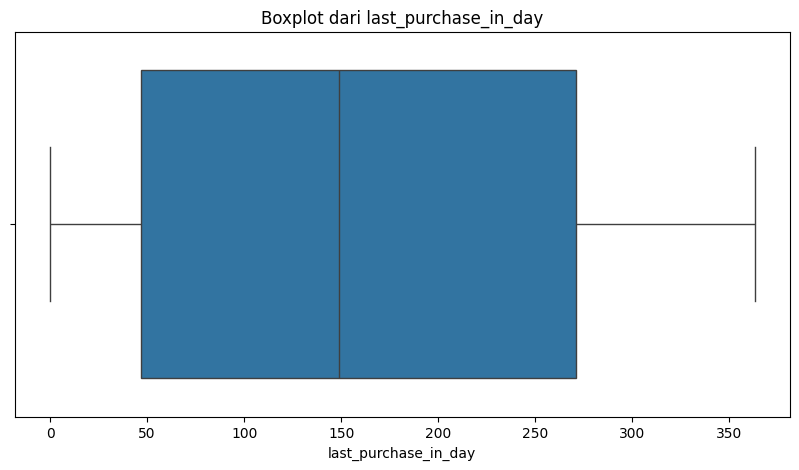

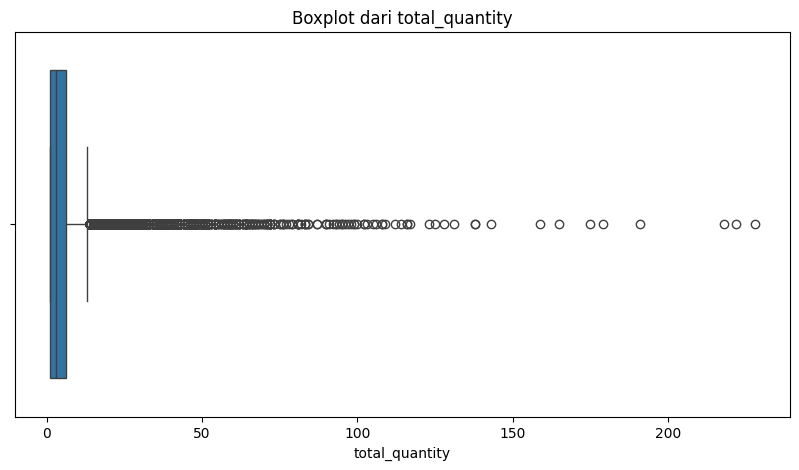

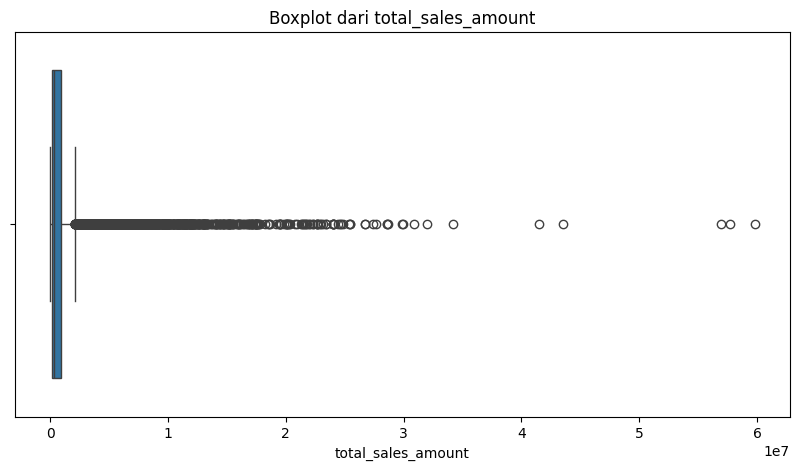

In [17]:
#boxplot
numeric_columns=df_cust_agg.select_dtypes("number").columns

for col in numeric_columns :
  plt.figure(figsize=(10,5))
  plt.title(f"Boxplot dari {col}")

  sns.boxplot(data=df_cust_agg,x=col)
  plt.show()


#dari hasil boxplot didapat bahwa kolom quantity dan sales amount memiliki banyak outlier

## Sebaran data dan Skewness

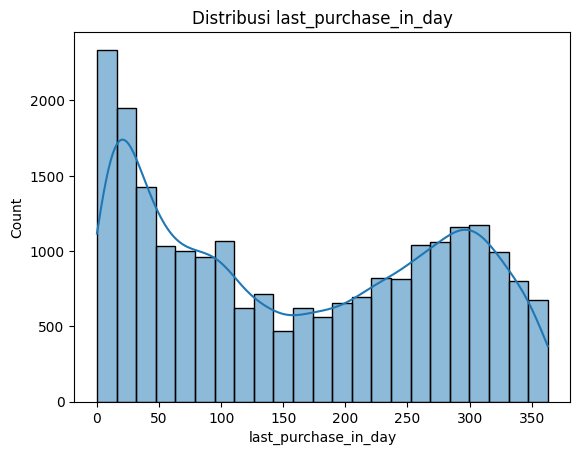

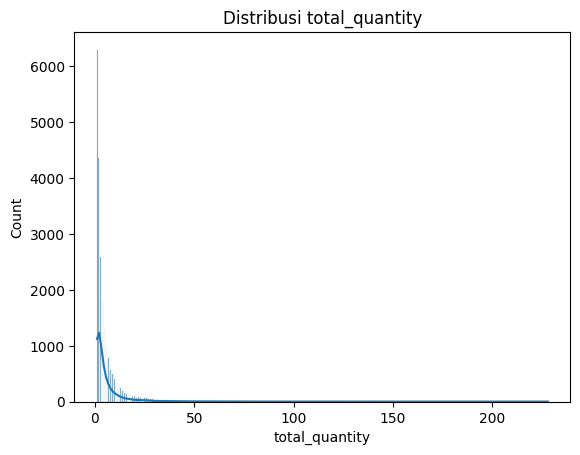

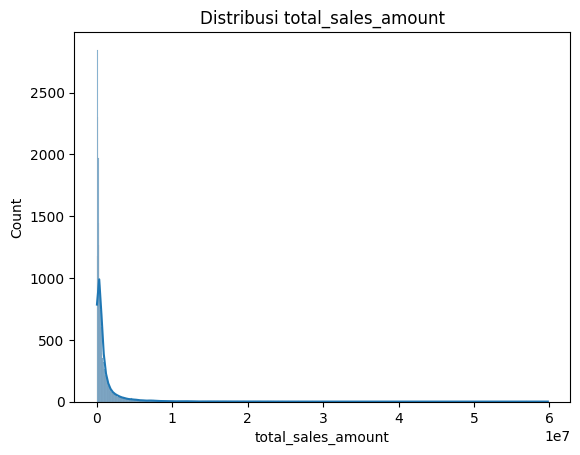

In [18]:
for col in numeric_columns :
  sns.histplot(df_cust_agg[col], kde=True)
  plt.title(f"Distribusi {col}")
  plt.show()

#dailihat dari skewness/kemiringan dari histogram  bisa dilihat bahwa dari segi quantity dan amount, most of them membeli dengan quantity kecil dan jumlah uang yg kecil

# Segmentasi Pelanggan menggunakan RFM

Dikarenakan terdapat outlier untuk tiap variabelnya,  scoring RFM memiliki rule :
1. Pelanggan yang masuk kategori outlier akan dikelompokan dengan nilai tertinggi berdasarkan uppper whisker dan dikategorikan dengan nilai R/F/M tertinggi yaitu 4
2. Pelanggan yang tidak termasuk outlier akan dibangi berdasarkan quantile 0.3, 0.6, 0.9 (nilai R/F/M hanya ada dikategori 1-3)
"""

## Scoring nilai R F M

In [19]:
#fungsi untuk mendapatakan batasan nilai yg dianggap outlier menggunakan upper whisqer (garis bagian atas boxplot)
def get_batas_outlier(df,col) :
  Q1 =df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  upper_whisker = Q3 + 1.5 * IQR
  upper_whisker
  return upper_whisker

In [20]:
# funtion untuk scoring nilai R Score, F Score, dan M Score
def scoring_with_outlier(df,col,batas_outlier,output_column_name) :

  # Pisahkan outlier
  outliers_mask = df[col] > batas_outlier
  normal_mask = ~outliers_mask

  # Kasih skor 5 buat yang outlier
  df.loc[outliers_mask,output_column_name] = '4'

  # Bagi sisanya jadi 4 bin (skor 1-4)
  df.loc[normal_mask, output_column_name] = pd.qcut(df.loc[normal_mask, col].rank(method='first'), q=[0, 0.3, 0.6, 1.0], labels=['1', '2', '3'])

  return df

def scoring_R_score(df,col) :

  # Bagi sisanya jadi 4 bin (skor 1-4)
  df["R_score"] = pd.qcut(df[col].rank(method='first'), q=4, labels=['4', '3', '2','1'])

  return df


In [21]:
#menentukan batas uppper_whisker
batas_outlier_total_quantity=get_batas_outlier(df_cust_agg,'total_quantity')
batas_outlier_total_sales_amount=get_batas_outlier(df_cust_agg,'total_sales_amount')

In [22]:
#apply function scoring
df_rfm=df_cust_agg.copy()
df_rfm=scoring_R_score(df_rfm,"last_purchase_in_day")
df_rfm=scoring_with_outlier(df_rfm,'total_quantity',batas_outlier_total_quantity,'F_score')
df_rfm=scoring_with_outlier(df_rfm,'total_sales_amount',batas_outlier_total_sales_amount,'M_score')
df_rfm

,customer_id,last_purchase_in_day,last_purchase_in_date,total_quantity,total_sales_amount,R_score,F_score,M_score
0,cust1,343,2025-01-22,2,244350.0,1,2,2
1,cust10,322,2025-02-12,1,1654650.0,1,1,3
2,cust100,362,2025-01-03,2,196950.0,1,2,2
3,cust1000,319,2025-02-15,1,323100.0,1,1,2
4,cust10000,228,2025-05-17,3,334200.0,2,2,2
...,...,...,...,...,...,...,...,...
22620,cust9995,10,2025-12-21,8,1515750.0,4,3,3
22621,cust9996,76,2025-10-16,9,1244700.0,3,3,3
22622,cust9997,120,2025-09-02,1,81450.0,3,2,1
22623,cust9998,171,2025-07-13,2,134850.0,2,2,1


## Labeling Segmentasi pelanggan berdasarkan kombinasi score RFM

In [23]:
def segmentasi_rfm(df):
    r = int(df['R_score'])
    f = int(df['F_score'])
    m = int(df['M_score'])

    if r == 4 and f == 4 and m == 4:
        return 'Champions'
    elif f == 4:
        return 'Loyal Customers'
    elif r == 4 and f >= 2:
        return 'Potential Loyalist'
    elif r == 4 and f == 1:
        return 'New Customers'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Others / About to Sleep'

In [24]:
# Terapkan ke DataFrame
df_rfm['segment'] = df_rfm.apply(segmentasi_rfm, axis=1)
df_rfm.segment.value_counts()

,count
segment,
Hibernating,7003
Others / About to Sleep,5324
At Risk,3911
Potential Loyalist,3453
Champions,1170
Loyal Customers,959
New Customers,805


# Export dataset RFM result

In [26]:
df_rfm.to_csv("dataset_rfm_result.csv",index=None)